Note: must turn off radar in settings before recording

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

#!unzip -u "/content/drive/My Drive/Archive.zip" -d "/content/drive/My Drive/"

#basically, save it to a 'colab data' folder
#then upload each file onto colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir("/content/drive/MyDrive/GTA Driving Data")
#!ls

In [4]:
#imports + file upload
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization

import time
import random
import numpy as np
from tqdm import tqdm
from PIL import Image

assert len(tf.config.list_physical_devices('GPU')) > 0

from google.colab import files
from skimage.color import rgb2gray
from collections import Counter
from random import shuffle
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt

#uploaded = files.upload()

In [15]:
#data processing

#next steps: use GAN to debias dataset (MIT 6.S191 lec 4, lab 2)

def data_processing(start_val,num_files):
  s_turn = []
  m_turn = []
  adj_turn = []
  no_turn = []
  balanced_data = []
  starting_value = start_val
  continue_loop = True
  start_time = time.time()
  while continue_loop:
    data_file_name = '/content/drive/MyDrive/GTA Driving Data/processed-training_data-{}.npy'.format(starting_value)
    if os.path.isfile(data_file_name) and starting_value < start_val + num_files:
      print(starting_value)
      starting_value += 1
      processed_data = np.load(data_file_name,allow_pickle=True)    
      #print(len(processed_data))
      #h+= 1
      #i = 0
      for entry in processed_data:
        #print(i)
        #i += 1
        #np_entry =print(entry[0])
        y = entry[0][0:3]
        y_ls = y[2]
        x= entry[1]
        #x = rgb2gray(entry[1])
        #flipping images
        y_flipped = [y[0],y[1],1-y_ls]
        x_flipped = cv2.flip(x, 1)
        #print(y_ls)
        if (y_ls > 0.875 or y_ls < 0.125):
          #very sharp turn, but it doesn't warrant its own array
          s_turn.append([x,y])
          #s_turn.append([x_flipped,y_flipped])
        elif (y_ls > 0.8 or y_ls < 0.2):
          #sharp turn
          #s_turn.append([x_flipped,y_flipped])
          s_turn.append([x,y])
        elif (y_ls > 0.7 or y_ls < 0.3):
          #medium turn
          m_turn.append([x,y])
          #m_turn.append([x_flipped,y_flipped])

        elif (y_ls > 0.65 or y_ls < 0.35):
          #light turn, doesn't warrant its own array
          m_turn.append([x,y])
          #m_turn.append([x_flipped,y_flipped])

        elif (y_ls > 0.575 or y_ls < 0.425):
          #adjustments
          adj_turn.append([x,y])
          #adj_turn.append([x_flipped,y_flipped])
        else:
          #no turn
          no_turn.append([x,y])
          #no_turn.append([x_flipped,y_flipped])
    else:
      if not (starting_value < start_val + num_files):
        continue_loop = False
      else:
        starting_value += 1

  shuffle(no_turn)
  #without shuffling, array adjustment in next step would mean that the training set is full of mirror repeats 
  #we would prefer to have [img12_mirrored,img1] rather than [img1_mirrored, img1]
  #shuffling allows for this

  """
  print(len(no_turn))
  print(len(s_turn))
  print(len(m_turn))
  print(len(adj_turn))
  """
  """
  arr_lengths = [len(no_turn),len(adj_turn),len(m_turn),len(s_turn)]
  arr_names = ["no turn","adjustment turn","medium turn", "sharp turn"]
  print("set up bar graph for adjusted list")
  h+= 1
  """
  balanced_data = s_turn + m_turn + adj_turn + no_turn[0:len(adj_turn)]

  arr_lengths = [len(adj_turn),len(adj_turn),len(m_turn),len(s_turn)]
  arr_names = ["no turn (trimmed)","adjustment turn","medium turn", "sharp turn"]
  
  plt.bar(arr_names,arr_lengths)
  plt.show()
  

  no_turn = []
  s_turn = []
  m_turn = []
  adj_turn = []
  shuffle(balanced_data)
  X = []
  Y = []
  for entry in balanced_data:
    entry[0] = rgb2gray(entry[0])


  X , Y = zip(*balanced_data)

  print("done! have {} test cases".format(len(balanced_data)))
  print("time to run time: {}".format(time.time()-start_time))
  balanced_data = []

  X_train_3dim = tf.convert_to_tensor(X)
  #Y = tf.convert_to_tensor(Y)

  print(X_train_3dim.shape)

  new_shape = list(X_train_3dim.shape) + [1]

  X_train = tf.reshape(X_train_3dim,new_shape)
  print(X_train.shape)

  Y_train_3dim = tf.convert_to_tensor(Y)
  #Y = tf.convert_to_tensor(Y)

  print(Y_train_3dim.shape)

  new_shape = list(Y_train_3dim.shape) + [1]

  Y_train = tf.transpose(tf.reshape(Y_train_3dim,new_shape),perm = [0,2,1])
  print(Y_train.shape)

  #we want agent to make small adjustments, so adj_turn isn't being adjusted
  #we don't want agent to just go straight, so less of no_turn is being added
  return X_train,Y_train

In [6]:
#saving chunk of training data as testing data

#PERCENT_TEST = 20

#test_index_start = int(PERCENT_TEST*len(balanced_data)/100)
#train_data = balanced_data[:-test_index_start]
#test_data = balanced_data[-test_index_start:]

In [7]:
#X_train = []
#Y_train = []

#for entry in train_data:
  #print(entry)
#  X_train.append(entry[0])
#  Y_train.append(entry[1])

#X_train = np.array(X_train)
#Y_train = np.array(Y_train)
"""

X_train_3dim = tf.convert_to_tensor(X)
#Y = tf.convert_to_tensor(Y)

print(X_train_3dim.shape)

new_shape = list(X_train_3dim.shape) + [1]

X_train = tf.reshape(X_train_3dim,new_shape)
print(X_train.shape)

Y_train_3dim = tf.convert_to_tensor(Y)
#Y = tf.convert_to_tensor(Y)

print(Y_train_3dim.shape)

new_shape = list(Y_train_3dim.shape) + [1]

Y_train = tf.transpose(tf.reshape(Y_train_3dim,new_shape),perm = [0,2,1])
print(Y_train.shape)
"""


'\n\nX_train_3dim = tf.convert_to_tensor(X)\n#Y = tf.convert_to_tensor(Y)\n\nprint(X_train_3dim.shape)\n\nnew_shape = list(X_train_3dim.shape) + [1]\n\nX_train = tf.reshape(X_train_3dim,new_shape)\nprint(X_train.shape)\n\nY_train_3dim = tf.convert_to_tensor(Y)\n#Y = tf.convert_to_tensor(Y)\n\nprint(Y_train_3dim.shape)\n\nnew_shape = list(Y_train_3dim.shape) + [1]\n\nY_train = tf.transpose(tf.reshape(Y_train_3dim,new_shape),perm = [0,2,1])\nprint(Y_train.shape)\n'

In [8]:
#new_shape_0 = [1] + list(X_train[0].shape)
#X_train_0= tf.reshape(X_train[0],new_shape_0)
"""
print(X_train[0:10].shape)
"""


'\nprint(X_train[0:10].shape)\n'

In [9]:
"""
print(Y_train.shape)
print(tf.transpose(Y_train,perm = [0,2,1]).shape)
"""
#new_shape_0 = [1] + list(X_train[0].shape)
#X_train_0 = tf.reshape(X_train[0],new_shape_0)
#print(X_train_0.shape)

'\nprint(Y_train.shape)\nprint(tf.transpose(Y_train,perm = [0,2,1]).shape)\n'

-------------STARTING EPOCH 0-------------
0
1
2
3
4
5
6
7
8
9


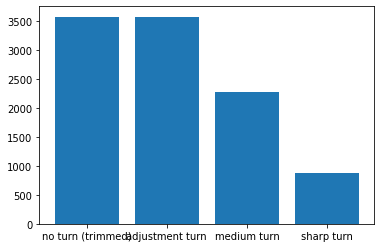

done! have 10282 test cases
time to run time: 34.847986936569214
(10282, 120, 160)
(10282, 120, 160, 1)
(10282, 3)
(10282, 1, 3)
322/322 [==============================] - 34s 102ms/step - loss: 0.0366 - accuracy: 0.7171
10
11
12
13
14
15
16
17
18
19


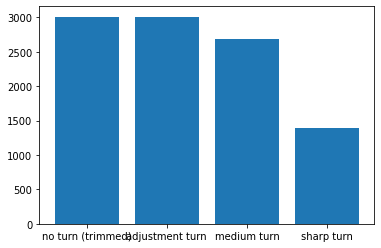

done! have 10096 test cases
time to run time: 36.12618446350098
(10096, 120, 160)
(10096, 120, 160, 1)
(10096, 3)
(10096, 1, 3)
316/316 [==============================] - 32s 103ms/step - loss: 0.0460 - accuracy: 0.7157
20
21
22
23
24
25
26
27
28
29


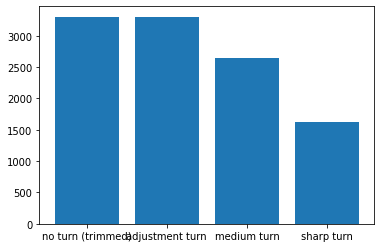

done! have 10874 test cases
time to run time: 36.229729890823364
(10874, 120, 160)
(10874, 120, 160, 1)
(10874, 3)
(10874, 1, 3)
340/340 [==============================] - 35s 103ms/step - loss: 0.0405 - accuracy: 0.7888
30
31
32
33
34
35
36
37
38
39


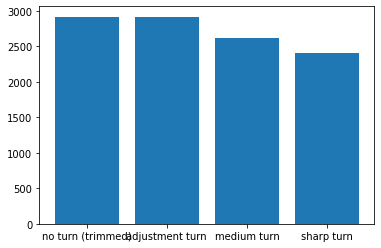

done! have 10861 test cases
time to run time: 35.26019239425659
(10861, 120, 160)
(10861, 120, 160, 1)
(10861, 3)
(10861, 1, 3)
340/340 [==============================] - 35s 103ms/step - loss: 0.0559 - accuracy: 0.5782
40
42
43
44
45
46
47
48
49


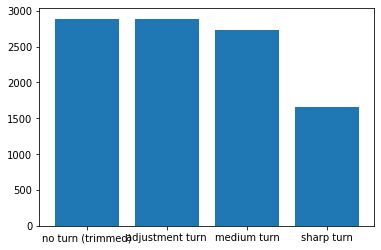

done! have 10164 test cases
time to run time: 32.58832406997681
(10164, 120, 160)
(10164, 120, 160, 1)
(10164, 3)
(10164, 1, 3)
318/318 [==============================] - 33s 103ms/step - loss: 0.0468 - accuracy: 0.7640
50
51
52
53
56
57
58
59


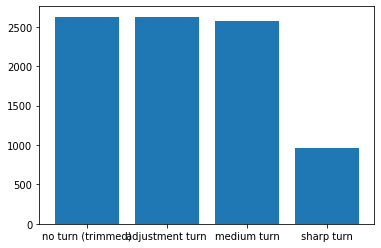

done! have 8788 test cases
time to run time: 27.977042198181152
(8788, 120, 160)
(8788, 120, 160, 1)
(8788, 3)
(8788, 1, 3)
275/275 [==============================] - 28s 103ms/step - loss: 0.0421 - accuracy: 0.8180
60
61
62
63
64
65
66
67
68
69


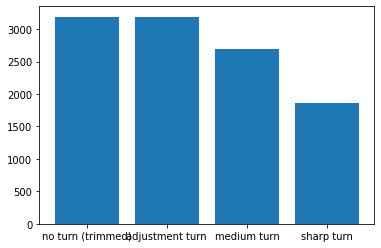

done! have 10929 test cases
time to run time: 34.23206186294556
(10929, 120, 160)
(10929, 120, 160, 1)
(10929, 3)
(10929, 1, 3)
342/342 [==============================] - 35s 102ms/step - loss: 0.0420 - accuracy: 0.7279
70
71
72
73
74
75
76
77
78
79


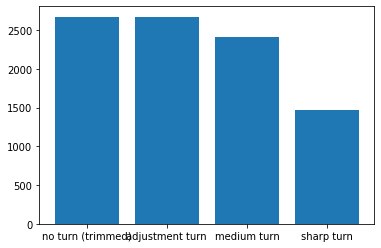

done! have 9229 test cases
time to run time: 35.496222734451294
(9229, 120, 160)
(9229, 120, 160, 1)
(9229, 3)
(9229, 1, 3)
289/289 [==============================] - 30s 103ms/step - loss: 0.0460 - accuracy: 0.6770
80
81
82
83
84
85
86
87
88
89


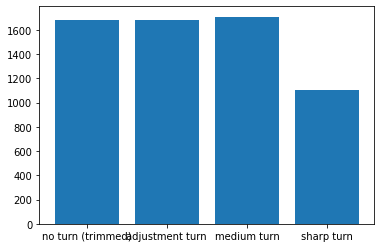

done! have 6183 test cases
time to run time: 28.28940486907959
(6183, 120, 160)
(6183, 120, 160, 1)
(6183, 3)
(6183, 1, 3)
194/194 [==============================] - 20s 103ms/step - loss: 0.0519 - accuracy: 0.6791
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


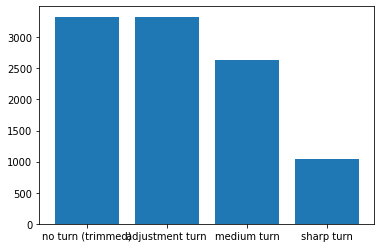

done! have 10322 test cases
time to run time: 67.45599293708801
(10322, 120, 160)
(10322, 120, 160, 1)
(10322, 3)
(10322, 1, 3)
323/323 [==============================] - 33s 103ms/step - loss: 0.0448 - accuracy: 0.7124
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


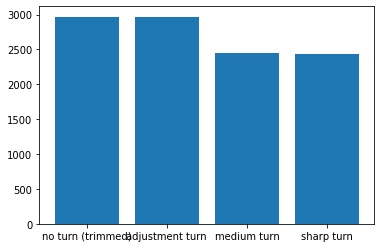

done! have 10819 test cases
time to run time: 64.17979264259338
(10819, 120, 160)
(10819, 120, 160, 1)
(10819, 3)
(10819, 1, 3)
339/339 [==============================] - 35s 102ms/step - loss: 0.0610 - accuracy: 0.6548
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170


In [ ]:

"""
import mxnet as mx
from mxnet import np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l
"""

#set up alexnet


def build_alexnet_model():
  #image_shape = (80,60,1)
  np.random.seed(1000)
  #https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer
  model = tf.keras.Sequential([
    #tf.keras.layers.InputLayer(input_shape=image_shape),
    tf.keras.layers.Conv2D(filters=96, kernel_size=(5,5),strides=(2,2),activation=tf.nn.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),activation=tf.nn.relu), 
    #tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    #tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4096, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation=tf.keras.activations.linear)])
  
  return model

def build_cnn_model():
      cnn_model = tf.keras.Sequential([
        # Here, we use a larger 11 x 11 window to capture objects. At the same
        # time, we use a stride of 2 to reduce the height and width of
        # the output. Here, the number of output channels is much larger than
        # that in LeNet
        tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=2,
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        # Make the convolution window smaller, set padding to 2 for consistent
        # height and width across the input and output, and increase the
        # number of output channels
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        # Use three successive convolutional layers and a smaller convolution
        # window. Except for the final convolutional layer, the number of
        # output channels is further increased. Pooling layers are not used to
        # reduce the height and width of input after the first two
        # convolutional layers
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Flatten(),
        # Here, the number of outputs of the fully-connected layer is several
        # times larger than that in LeNet. Use the dropout layer to mitigate
        # overfitting
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        # Output layer. Since we are using Fashion-MNIST, the number of
        # classes is 10, instead of 1000 as in the paper
        tf.keras.layers.Dense(3)])
      
      return cnn_model

cnn_model = build_cnn_model()
cnn_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1), 
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

#x = np.random.rand(2,160,120,1)
#X = tf.convert_to_tensor(x)

# Initialize the model by passing some data through
#predictions = cnn_model.predict(X_train_0)
#print(predictions)
#print(predictions.shape)
# Print the summary of the layers in the model.
#print(cnn_model.summary())

BATCH_SIZE = 32
EPOCHS = 20
start_val = 0
num_files_to_retrieve = 10
num_files_to_test = 215
for epoch in range(0,EPOCHS):
  print('-------------STARTING EPOCH {}-------------'.format(epoch))
  start_val = 0
  while start_val < num_files_to_test-num_files_to_retrieve*3:
    if(start_val < 83):
      X_train, Y_train = data_processing(start_val,num_files_to_retrieve)
      start_val += num_files_to_retrieve
    else:
      X_train, Y_train = data_processing(start_val,num_files_to_retrieve*3)
      start_val += num_files_to_retrieve*3
    cnn_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=1)
  X_train, Y_train = data_processing(start_val,num_files_to_test-start_val+1)
  cnn_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=1)



X_test, Y_test = data_processing(216,18)
test_loss, test_acc = cnn_model.evaluate(X_test,Y_test)

#test_loss, test_acc = cnn_model.evaluate(X_train[-1000:], Y_train[-1000:])

print('Test accuracy:', test_acc)

#TODO: record, setup training loop, test it out
#record just 5 mins to test out data processing at alexnet dims

In [ ]:
"""
#defining lstm model
#rnn is later
def build_LSTM_model():#vocab_size, embedding_dim, rnn_units, batch_size):
  model = keras.Sequential(
      [
       layers.ConvLSTM2D(
           filters=40,kernel_size=(3,3),padding='same',return_sequences=True
       ),
       layers.BatchNormalization(),
       layers.ConvLSTM2D(
           filters=40,kernel_size=(3,3),padding='same',return_sequences=True
       ),
       layers.BatchNormalization()
       ])
  model.compile(loss=keras.losses.MeanSquaredError(),optimizer='adam',metrics=["accuracy"])
  return model

x = np.random.rand(2,120,160,1)
X = tf.convert_to_tensor(x)
print(X.shape)
rnn_model = build_LSTM_model()
# Initialize the model by passing some data through
predictions = rnn_model.predict(X)

#print(predictions)
# Print the summary of the layers in the model.
print(rnn_model.summary())



    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    # TODO: Call the LSTM function defined above to add this layer.
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    # TODO: Add the Dense layer.
    tf.keras.layers.Dense(vocab_size)
  ])
"""

  #return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
#model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [ ]:
#figure out batches w/ input data, set that up, break them down into 100 frames

In [ ]:
#train + save weights ever once in a while